In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import descartes

In [2]:
import numpy as np

In [3]:
import shapely
import shapely.wkt
from collections import deque

In [4]:
#path to the raw school district file and the raw precinct file
#I unzipped both zip files
districts_shp_path = 'districts/districts/School_Districts_1920.shp'
districts_frame = gpd.read_file(districts_shp_path)
districts_frame['geometry'] = districts_frame['geometry'].buffer(0)
general_shp_path = 'general/general/2016General.shp'
general_frame = gpd.read_file(general_shp_path)
school_voter_path = 'DistrictVoterData.csv'
voting_frame = pd.read_csv(school_voter_path)

In [5]:
general_frame['geometry'] = general_frame['geometry'].buffer(0)
districts_frame['geometry'] = districts_frame['geometry'].buffer(0)

In [8]:
districts_frame = districts_frame[['DISTRICT_N', 'geometry']]
super_districts_path = 'ESC_Regions.shp'
super_districts_frame = gpd.read_file(super_districts_path)
super_districts_frame['geometry'] = super_districts_frame['geometry'].buffer(0)

In [9]:
super_districts_frame = super_districts_frame[['REGION','geometry']]

In [12]:
#is cleaning up the school district, with the region. They weren't extactly perfect so we mapped
#the school district with its super region if it had a 90% overlap
output_super_join = gpd.sjoin(districts_frame.to_crs('EPSG:4326'),super_districts_frame, op = 'intersects')
output_super_join['percent_overlap'] = output_super_join.apply(lambda x: x['geometry'].intersection(super_districts_frame.iloc[x['index_right']]['geometry']).area / x['geometry'].area*100, axis=1)     
output_super_join = output_super_join[output_super_join.percent_overlap > 90]

In [277]:
#returns the top votes grouped by newly allocated region
def recalculate_top_votes(total_votes):
    voting_region = total_votes.groupby('NEWLY_ALLOCATED').sum()
    voting_region = voting_region[['VOTES']].sort_values('VOTES', ascending = False)
    voting_region = voting_region.reset_index()
    return voting_region

In [280]:
#this takes in a geopandas frame, and retruns the index in the frame, that has the northernmost point 
def find_starting_geom(district_frame):
    g = [i for i in district_frame.geometry]
    all_coords = []
    i = 0
    for geo in g:
        #if (type(geo) == shapely.geometry.Polygon):
        coords = []
        if (str(geo.type) == 'Polygon'):
            transition = list(geo.exterior.coords)
            for point in transition:
                coords.append(point)
        #is of type multipolygon
        else:
            flat_list = []
            list_poly = []
            for poly in geo:
                list_poly.append(list(poly.exterior.coords))
            for poly in list_poly:
                for point in poly:
                    flat_list.append(point)

        all_coords.append((i, coords))
        i+= 1
    index_southernest = -1;
    furthest_total = -1;
    for school in all_coords:
        furthest_coord_y = -1;
        for point in school[1]:
            if (point[1] > furthest_coord_y):
                furthest_coord_y = point[1]
        if (furthest_coord_y > furthest_total):
            index_southernest = school[0]
            furthest_total = furthest_coord_y
    return index_southernest

In [281]:
from math import radians, cos, sin, asin, sqrt
#used for centroid distance calculation
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 6371 for kilometers
    return c * r

In [389]:
#Join up the school district frame, with the voting frame on district_n
join_w_data = output_super_join.join(voting_frame.set_index('DISTRICT_N'), on='DISTRICT_N' ,how = 'left')
join_w_data['NEWLY_ALLOCATED'] = join_w_data['REGION'].astype(int)
join_w_data.head()

,DISTRICT_N,geometry,index_right,REGION,percent_overlap,PTY,VOTES,NEWLY_ALLOCATED
0,73901,"POLYGON ((-96.99308 31.40669, -96.99297 31.406...",11,12,100.0,D,178.0,12
0,73901,"POLYGON ((-96.99308 31.40669, -96.99297 31.406...",11,12,100.0,I,17.0,12
0,73901,"POLYGON ((-96.99308 31.40669, -96.99297 31.406...",11,12,100.0,R,480.0,12
76,18908,"POLYGON ((-97.75760 31.85712, -97.75616 31.855...",11,12,100.0,D,85.0,12
76,18908,"POLYGON ((-97.75760 31.85712, -97.75616 31.855...",11,12,100.0,I,10.0,12


In [390]:
voting_region = join_w_data.groupby('NEWLY_ALLOCATED').sum()
voting_region = voting_region[['VOTES']].sort_values('VOTES', ascending = False)
voting_region = voting_region.reset_index()
voting_region.head()

,NEWLY_ALLOCATED,VOTES
0,4,1774277.0
1,10,1272735.0
2,11,1102963.0
3,13,967361.0
4,20,664822.0


In [394]:
join_w_data['NEWLY_ALLOCATED'] = join_w_data['REGION'].astype(int)
top_votes = 0
#16 new regions
for i in range(21,37):
    #get the top region without replacmenet in terms of votes
    district_to_split = voting_region.iloc[0+top_votes]
    
    #progress_bar
    print(i)
   
    #Region to split on
    region_split_on = voting_region.iloc[0+top_votes]['NEWLY_ALLOCATED']
    total_votes_needed = district_to_split['VOTES'] /2
    districts_to_seperate = join_w_data.loc[join_w_data['NEWLY_ALLOCATED'] == district_to_split['NEWLY_ALLOCATED']]
    districts_to_seperate = districts_to_seperate.reset_index()
    
    #starting index that we are splitting on
    index_starting = find_starting_geom(districts_to_seperate) 
    district_num = districts_to_seperate.iloc[index_starting]['DISTRICT_N']
    
    #stack implementation for adding districts
    total_votes = 0
    neighbor_stack = deque()
    neighbor_stack.append(district_num)
    newRegion = []
    
    #inital district is already in stack. will continue going until neighbor stack is empty or votes are reached.
    while(total_votes < total_votes_needed):
        district = neighbor_stack.popleft()
        newRegion.append(district)
        iterative_votes = districts_to_seperate.loc[districts_to_seperate['DISTRICT_N'] == district]['VOTES'].sum()
        geom_this_district = districts_to_seperate.loc[districts_to_seperate['DISTRICT_N'] == district].drop_duplicates('DISTRICT_N')
        neighbors = districts_to_seperate[districts_to_seperate.geometry.touches(geom_this_district.iloc[0]['geometry'])]
        unique_neighbors = neighbors['DISTRICT_N'].unique()
        for uniq in unique_neighbors:
            if uniq not in neighbor_stack and uniq not in newRegion:
                neighbor_stack.append(uniq)
        total_votes += iterative_votes
    
    #reset district to the new split number
    for district in newRegion:
        join_w_data.loc[join_w_data.DISTRICT_N == district, 'NEWLY_ALLOCATED'] = i
    reassigners.append((i, region_split_on, newRegion))
    top_votes+=1

21
4.0
1774277.0
[146904, 146907, 146905, 146906, 146902, 146901, 146903, 36901, 101925, 36902, 101906, 36903, 84902, 84901, 101911, 101913, 84910, 101916, 101924, 84906, 20905, 20902, 84908, 84909, 101908, 101905, 101902, 101912, 101917]
deque([20908, 84911, 101910, 20906, 20907, 79901, 79906, 20901, 20904, 79907, 101919, 101915, 101907, 101920, 79910, 101903, 101914])


22
10.0
1272735.0
[91909, 91914, 91913, 91902, 91906, 91905, 91917, 91903, 91907, 91901, 91918, 91908, 43903, 74911, 91910, 43902, 43907, 43912, 74905, 74903, 74912, 43917, 43908, 43919, 43901, 43905, 43911, 74917, 74904, 74907, 116909, 74909, 43904, 116902, 116915, 43910, 43914, 43918, 116903, 116905, 116901, 57916, 57909, 57905]
deque([57903, 199901, 199902, 116910, 116906, 116908, 57914, 57919, 57913, 57911, 57907, 57906, 70905, 129901, 57912, 57910, 129902])


23
11.0
1102963.0
[49909, 49902, 49907, 49901, 49906, 49905, 49903, 61908, 249908, 49908, 61903, 61905, 61901, 249901, 249905, 61907, 61906, 61912, 61910, 6

In [392]:
join_w_data.to_file('nearest_neighbor_queue.shp')

In [393]:
recalculate_top_votes(join_w_data)

,NEWLY_ALLOCATED,VOTES
0,21,890301.0
1,4,883976.0
2,22,840972.0
3,24,602758.0
4,23,577615.0
5,11,525348.0
6,25,445371.0
7,10,431763.0
8,13,364603.0
9,20,219451.0


<AxesSubplot:>

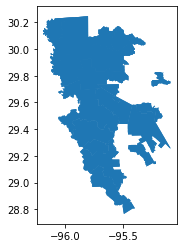

In [376]:
join_w_data.loc[join_w_data['NEWLY_ALLOCATED'] == 4]['geometry'].plot()

<AxesSubplot:>

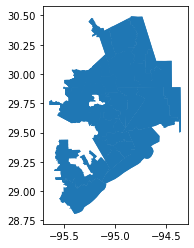

In [377]:
join_w_data.loc[join_w_data['NEWLY_ALLOCATED'] == 21]['geometry'].plot()

<AxesSubplot:>

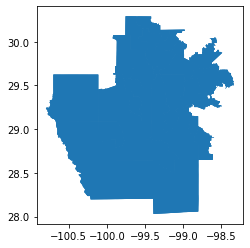

In [378]:
join_w_data.loc[join_w_data['NEWLY_ALLOCATED'] == 25]['geometry'].plot()

<AxesSubplot:>

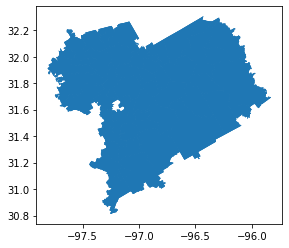

In [379]:
join_w_data.loc[join_w_data['NEWLY_ALLOCATED'] == 28]['geometry'].plot()